In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",999)

In [3]:
train = pd.read_csv('../train.csv')
train.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [4]:
test = pd.read_csv('../test.csv')

In [5]:
weather = pd.read_csv('../weather.csv')

---

In [6]:
#Date

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)
weather.Date = pd.to_datetime(weather.Date)

In [7]:
#Keeping only the weather data of interest

weather_data = weather.drop(["SnowFall","Water1", "Depth", "WetBulb", "DewPoint", "Sunrise", "Sunset", "CodeSum"], axis=1)
weather_data["Day_of_year"] = weather_data.Date.apply(lambda c:c.dayofyear)

In [8]:
def validated_value(series): #temp code
    listy = list(series)
    try: 
        validated_value = float(listy[0])
        return validated_value
    except:
        try:
            validated_value = float(listy[1])
            return validated_value
        except: 
            return listy[0]

In [9]:
weather_data_filt1 = weather_data.pivot_table(index="Date", aggfunc=validated_value)

In [10]:
weather_data_filt1[weather_data_filt1.StnPressure=="M"]

,AvgSpeed,Cool,Day_of_year,Depart,Heat,PrecipTotal,ResultDir,ResultSpeed,SeaLevel,Station,StnPressure,Tavg,Tmax,Tmin
Date,,,,,,,,,,,,,,
2013-08-10,6.5,8.0,222,0.0,0.0,0,5,5.3,30.08,1,M,73.0,81,64


I fill in the missing value (M) by looking at the trend

In [11]:
for_obs = weather_data_filt1[(weather_data_filt1.index >= "2013") & (weather_data_filt1.index < "2014")]

[]

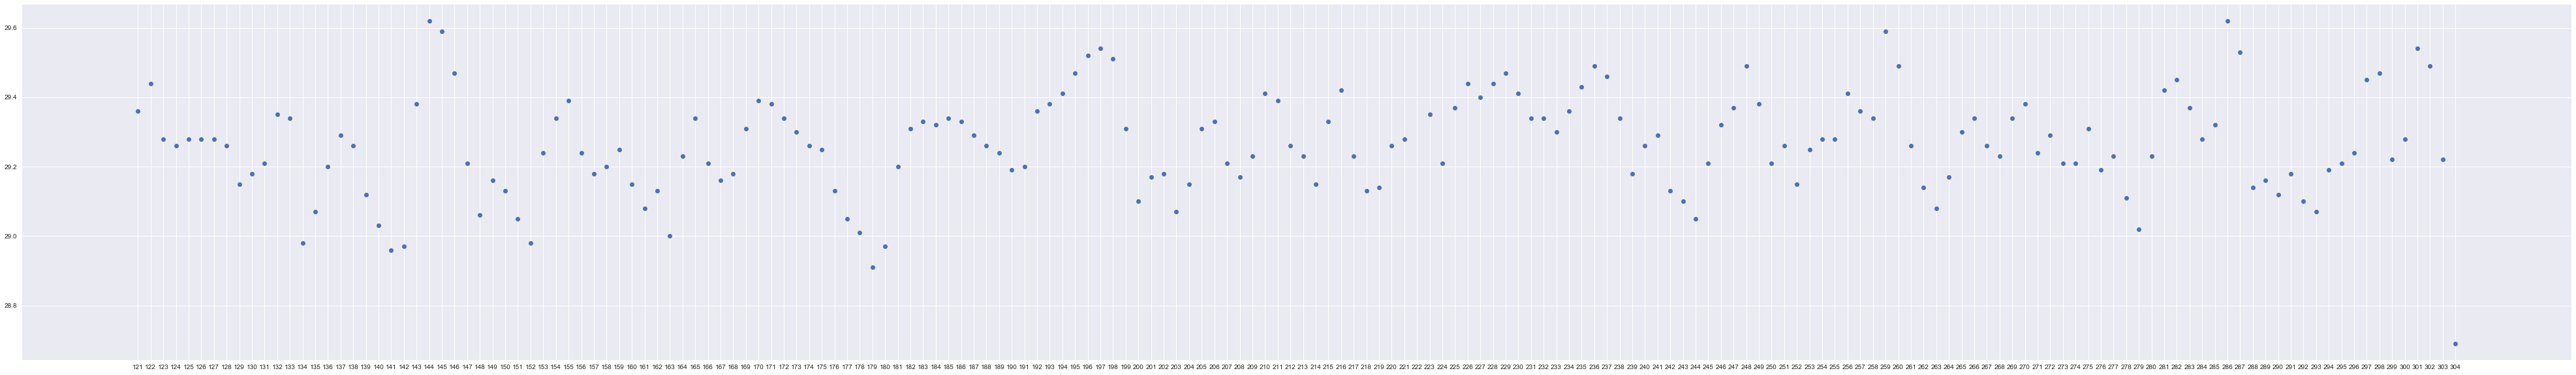

In [12]:
plt.figure(figsize=(70,10))
plt.plot_date(for_obs[for_obs.StnPressure!="M"].index, for_obs[for_obs.StnPressure!="M"].StnPressure)
plt.xticks(for_obs.index, for_obs["Day_of_year"])
plt.plot()

In [13]:
weather_data_filt1.loc["2013-08-10","StnPressure"]=29.28

In [14]:
weather_data_filt1['StnPressure']=weather_data_filt1.StnPressure.astype(float)

Dealing with T values (T=Trace)

In [15]:
max(weather_data_filt1[(weather_data_filt1.PrecipTotal.apply(lambda x:type(x)!=str)) &(weather_data_filt1.PrecipTotal>0)].PrecipTotal.values)

6.86

In [16]:
min(weather_data_filt1[(weather_data_filt1.PrecipTotal.apply(lambda x:type(x)!=str)) &(weather_data_filt1.PrecipTotal>0)].PrecipTotal.values)

0.01

Arbitrarily, I'll replace "Trace" with 0.001

In [17]:
for date in weather_data_filt1.index:
    if type(weather_data_filt1.loc[date,"PrecipTotal"]) != float:
        weather_data_filt1.loc[date,"PrecipTotal"]=0.001

In [18]:
weather_data_filt1["PrecipTotal"]=weather_data_filt1.PrecipTotal.astype(float)

-

In [19]:
weather_data_filt1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 14 columns):
AvgSpeed       1472 non-null float64
Cool           1472 non-null float64
Day_of_year    1472 non-null int64
Depart         1472 non-null float64
Heat           1472 non-null float64
PrecipTotal    1472 non-null float64
ResultDir      1472 non-null int64
ResultSpeed    1472 non-null float64
SeaLevel       1472 non-null float64
Station        1472 non-null int64
StnPressure    1472 non-null float64
Tavg           1472 non-null float64
Tmax           1472 non-null int64
Tmin           1472 non-null int64
dtypes: float64(9), int64(5)
memory usage: 172.5 KB


In [20]:
weather_data_filt1.drop("Station", axis=1, inplace=True)

In [21]:
train_and_weather = train.merge(weather_data_filt1, left_on = 'Date', right_index=True, how='inner')
test_and_weather = test.merge(weather_data_filt1, left_on = 'Date', right_index=True, how='inner')

In [26]:
train_and_weather_ = train_and_weather.drop(["ResultDir","AddressAccuracy","NumMosquitos","Date","Address","Block","Street","AddressNumberAndStreet"], axis=1)
#resultant direction is in degrees. should be a category

In [23]:
test_and_weather_ = test_and_weather.drop(["ResultDir","AddressAccuracy","Date","Address","Block","Street","AddressNumberAndStreet"], axis=1)

In [27]:
train_and_weather_.head()

,Species,Trap,Latitude,Longitude,WnvPresent,AvgSpeed,Cool,Day_of_year,Depart,Heat,PrecipTotal,ResultSpeed,SeaLevel,StnPressure,Tavg,Tmax,Tmin
0,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0,6.5,9.0,149,10.0,0.0,0.0,5.8,30.11,29.39,74.0,88,60
1,CULEX RESTUANS,T002,41.954690,-87.800991,0,6.5,9.0,149,10.0,0.0,0.0,5.8,30.11,29.39,74.0,88,60
2,CULEX RESTUANS,T007,41.994991,-87.769279,0,6.5,9.0,149,10.0,0.0,0.0,5.8,30.11,29.39,74.0,88,60
3,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,0,6.5,9.0,149,10.0,0.0,0.0,5.8,30.11,29.39,74.0,88,60
4,CULEX RESTUANS,T015,41.974089,-87.824812,0,6.5,9.0,149,10.0,0.0,0.0,5.8,30.11,29.39,74.0,88,60


-

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

### Trying KNN without CodeSum & using Traps before location

__First Model Attempts__

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

--

__First Trap & Species__

In [ ]:
#Scaling. (I scale by trap, but not by species due to numbers difference for rare ones)
scaler = StandardScaler().fit(train_and_weather_[(train_and_weather_.Trap=="T002")].drop(["Species",
                                                                                          "Trap",
                                                                                          "Latitude", 
                                                                                          "Longitude",
                                                                                          "WnvPresent"], axis=1))

In [ ]:
first_training_data_ = train_and_weather_[(train_and_weather_.Species=="CULEX PIPIENS") 
                                          & (train_and_weather_.Trap=="T002")].copy().reset_index(drop=True)
first_training_data_.drop(["Species","Trap","Latitude", "Longitude"], axis=1, inplace=True)

In [ ]:
std_Xtrain = scaler.transform(first_training_data_.drop("WnvPresent", axis=1))
#std_Xtest = scaler.transform...

y = first_training_data_['WnvPresent']

In [ ]:
for max in reversed(range(1,len(y))):
    try:
        params = {'n_neighbors':range(1,max)}
        clf_knn= KNeighborsClassifier()
        clf = GridSearchCV(clf_knn, params, cv=2, scoring='roc_auc')
        model = clf.fit(std_Xtrain,y)
        break
    except:
        continue
    
print model.best_score_
print model.best_params_

In [ ]:
params = {'n_neighbors':range(1,max)}
clf_knn= DecisionTreeClassifier()
clf = GridSearchCV(clf_knn, params, cv=2, scoring='roc_auc')
model = clf.fit(std_Xtrain,y)

    
print model.best_score_
print model.best_params_

In [33]:
first_training_data_.WnvPresent.value_counts(normalize=True)

0    0.829268
1    0.170732
Name: WnvPresent, dtype: float64

__Generalisation__

*IMPORTANT NOTE:*

*The KNN modus operandi comes in itself with a long computation (pairwise distance).*

*These very large datasets (both train & test data) and the following approach (one model per trap and species, tuned with gridsearch) make this code EXTREMELY slow to use (think in terms of an hour for the train dataset).*

In [34]:
train_w_preds= train_and_weather_.copy()

In [35]:
for trap in train_and_weather_["Trap"].unique():
    scaler = StandardScaler().fit(train_and_weather_[(train_and_weather_.Trap==trap)].drop(["Species",
                                                                                              "Trap",
                                                                                              "Latitude", 
                                                                                              "Longitude",
                                                                                              "WnvPresent"], axis=1))

    for species in train_and_weather_["Species"].unique():
        training_data_ = train_and_weather_[(train_and_weather_.Species==species) 
                                                  & (train_and_weather_.Trap==trap)].copy().reset_index(drop=True)
        if training_data_.shape[0]==0:
            
            continue
        
        else:
            training_data_.drop(["Species","Trap","Latitude", "Longitude"], axis=1, inplace=True)
     
            std_Xtrain = scaler.transform(training_data_.drop("WnvPresent", axis=1))
            #std_Xtest = scaler.transform...
            y = training_data_['WnvPresent']

            for max in reversed(range(1,len(y))):
                try:
                    params = {'n_neighbors':range(1,max)}
                    clf_knn= KNeighborsClassifier()
                    clf = GridSearchCV(clf_knn, params, cv=2, scoring='accuracy')
                    model = clf.fit(std_Xtrain,y)
                    break
                except:
                    continue

            predictions = [x[0]-1.0 for x in model.predict_proba(std_Xtrain)]
            train_w_preds.loc[(train_w_preds.Species==species) 
                                                  & (train_w_preds.Trap==trap),"Pred"]=predictions
            k = model.best_params_['n_neighbors']
            train_w_preds.loc[(train_w_preds.Species==species) 
                                                  & (train_w_preds.Trap==trap),"K"]=k


//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


__Evaluating the predictions made with the train dataset__

In [68]:
train_w_AUCpreds = pd.read_csv("train_w_AUCpreds.csv")

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

__Metric of interest for the Kaggle leaderboard__

In [114]:
roc_auc_score(train_w_AUCpreds.WnvPresent, train_w_AUCpreds.Pred)

0.6054172086549181

__Specifics__

In [111]:
train_w_AUCpreds.WnvPresent.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [112]:
train_w_AUCpreds.Pred.value_counts()

0.0    10374
1.0      132
Name: Pred, dtype: int64

In [113]:
confusion_matrix(train_w_AUCpreds.WnvPresent, train_w_AUCpreds.Pred)

array([[9940,   15],
       [ 434,  117]])

In [70]:
print classification_report(train_w_AUCpreds.WnvPresent, train_w_AUCpreds.Pred)

             precision    recall  f1-score   support

          0       0.96      1.00      0.98      9955
          1       0.89      0.21      0.34       551

avg / total       0.95      0.96      0.94     10506



It is obvious that the recall of the prediction model for positive cases is its main weakness, while the precision is very good.
In other words, positive presence of the virus is seldom found, but positive predictions are reliable (FOR THIS TRAINING DATA).

___This could make this model a reliable part of an ensemble___

In [45]:
"""train_w_preds.to_csv('train_w_pred_probas.csv', index_label=False )"""

__Applying to test_data__

for traps not in the train document, try using KNN to replace them with the closest trap.
for UNSPECIFIED CULEX, can use boolean indexing to fill with 0 (or prior probability of the least frequent species, if I get to the probability stage...)

In [30]:
for_knn_traps = train_and_weather_[["Trap", "Latitude", "Longitude"]]

In [31]:
for_knn_traps = for_knn_traps.pivot_table(index="Trap",values=["Latitude","Longitude"])

In [32]:
print len(train_and_weather_.Trap.unique())
print len(for_knn_traps.index)

136
136


In [33]:
knn_traps = KNeighborsClassifier(n_neighbors = 1)
model = knn_traps.fit(for_knn_traps,for_knn_traps.index) 

In [40]:
#new dataframe to input the closest traps
test_w_pred_traps = test_and_weather_.copy()

In [41]:
#not the most direct code, but does the job for now
trap_groups = test_and_weather_[["Trap", "Latitude", "Longitude"]].groupby(by="Trap")
for trap in list(set(train.Trap).symmetric_difference(set(test.Trap))):
    pred = model.predict(trap_groups.get_group(trap)[['Latitude','Longitude']])
    test_w_pred_traps.loc[(test_w_pred_traps["Trap"]==trap),"Trap"]=pred[0]

In [42]:
test_w_preds = test_w_pred_traps.copy()

In [50]:
concat_for_scaling = pd.concat([train_and_weather_, test_w_pred_traps])

In [51]:
for trap in train_and_weather_["Trap"].unique():
    scaler = StandardScaler().fit(concat_for_scaling[(concat_for_scaling.Trap==trap)].drop(["Species",
                                                                                              "Trap",
                                                                                              "Latitude", 
                                                                                              "Longitude",
                                                                                              "WnvPresent", "Id"], axis=1))

    for species in train_and_weather_["Species"].unique():
        training_data_ = train_and_weather_[(train_and_weather_.Species==species) 
                                                  & (train_and_weather_.Trap==trap)].copy().reset_index(drop=True)
        test_data_ = test_w_pred_traps[(test_w_pred_traps.Species==species) 
                                                  & (test_w_pred_traps.Trap==trap)].copy().reset_index(drop=True)
        if training_data_.shape[0]==0:

            test_w_preds.loc[(test_w_preds.Species==species) 
                                                  & (test_w_preds.Trap==trap),"Pred"]=0
            continue
        
        else:
            training_data_.drop(["Species","Trap","Latitude", "Longitude"], axis=1, inplace=True)
            test_data_.drop(["Id","Species","Trap","Latitude", "Longitude"], axis=1, inplace=True)
     
            std_Xtrain = scaler.transform(training_data_.drop("WnvPresent", axis=1))
            std_Xtest = scaler.transform(test_data_)
            y = training_data_['WnvPresent']

            for max in reversed(range(1,len(y))):
                try:
                    params = {'n_neighbors':range(1,max)}
                    clf_knn= KNeighborsClassifier()
                    clf = GridSearchCV(clf_knn, params, cv=2, scoring='accuracy')
                    model = clf.fit(std_Xtrain,y)
                    break
                except:
                    continue

            predictions = model.predict(std_Xtest)
            test_w_preds.loc[(test_w_preds.Species==species) 
                                                  & (test_w_preds.Trap==trap),"Pred"]=predictions


//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


In [59]:
test_w_preds.head()

,Id,Species,Trap,Latitude,Longitude,AvgSpeed,Cool,Day_of_year,Depart,Heat,PrecipTotal,ResultDir,ResultSpeed,SeaLevel,StnPressure,Tavg,Tmax,Tmin,Pred
0,1,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,10.0,9.0,163,7.0,0.0,0.0,18,8.9,29.99,29.28,74.0,86,61,0.0
1,2,CULEX RESTUANS,T002,41.95469,-87.800991,10.0,9.0,163,7.0,0.0,0.0,18,8.9,29.99,29.28,74.0,86,61,0.0
2,3,CULEX PIPIENS,T002,41.95469,-87.800991,10.0,9.0,163,7.0,0.0,0.0,18,8.9,29.99,29.28,74.0,86,61,0.0
3,4,CULEX SALINARIUS,T002,41.95469,-87.800991,10.0,9.0,163,7.0,0.0,0.0,18,8.9,29.99,29.28,74.0,86,61,0.0
4,5,CULEX TERRITANS,T002,41.95469,-87.800991,10.0,9.0,163,7.0,0.0,0.0,18,8.9,29.99,29.28,74.0,86,61,0.0


In [54]:
"""test_w_preds.to_csv('test_w_preds.csv', index=False)"""

__Initital submission__

In [64]:
submission = pd.DataFrame({'Id':test_w_preds.Id,'WnvPresent':test_w_preds.Pred})
submission.to_csv('init_sub.csv',index=False)

In [71]:
submission.shape

(116293, 2)

__Result from Leaderboard: 0.50248__

In [ ]:
# not good :). Apart from the fact the weather data should be examined for what it is BEFORE the date of examination, 
# KNN is most likely not a good choice (here, the similarity it catches fails to go beyond the training data)

---

### Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer

In [29]:
#to store predictions
train_w_preds= train_and_weather_.copy()

In [30]:
train_and_weather_lb= train_and_weather_.copy()

In [31]:
lb = LabelBinarizer()
trap_dummy_var = lb.fit_transform(train_and_weather_lb["Trap"])
trap_dummy_var = pd.DataFrame(trap_dummy_var)

In [32]:
train_and_weather_lb = train_and_weather_lb.drop("Trap", axis=1).join(trap_dummy_var)

In [36]:
train_and_weather_lb.ix[:,4:16]

,AvgSpeed,Cool,Day_of_year,Depart,Heat,PrecipTotal,ResultSpeed,SeaLevel,StnPressure,Tavg,Tmax,Tmin
0,6.5,9.0,149,10.0,0.0,0.00,5.8,30.11,29.39,74.0,88,60
1,6.5,9.0,149,10.0,0.0,0.00,5.8,30.11,29.39,74.0,88,60
2,6.5,9.0,149,10.0,0.0,0.00,5.8,30.11,29.39,74.0,88,60
3,6.5,9.0,149,10.0,0.0,0.00,5.8,30.11,29.39,74.0,88,60
4,6.5,9.0,149,10.0,0.0,0.00,5.8,30.11,29.39,74.0,88,60
5,6.5,9.0,149,10.0,0.0,0.00,5.8,30.11,29.39,74.0,88,60
6,6.5,9.0,149,10.0,0.0,0.00,5.8,30.11,29.39,74.0,88,60
7,6.5,9.0,149,10.0,0.0,0.00,5.8,30.11,29.39,74.0,88,60
8,6.5,9.0,149,10.0,0.0,0.00,5.8,30.11,29.39,74.0,88,60
9,6.5,9.0,149,10.0,0.0,0.00,5.8,30.11,29.39,74.0,88,60


In [37]:
scaler = StandardScaler()

train_and_weather_lb.ix[:,4:16] = scaler.fit_transform(train_and_weather_lb.ix[:,4:16])

In [61]:
#WITH RFC (no 'by-trap')

for species in train_and_weather_["Species"].unique():
    training_data_ = train_and_weather_lb[(train_and_weather_lb.Species==species)].copy().reset_index(drop=True)
    if training_data_.shape[0]==0:
        # give prediction of 0 for test, then
        continue

    else:
        std_Xtrain = training_data_.drop(["Species","Latitude", "Longitude", "WnvPresent"], axis=1)
        
        y = training_data_['WnvPresent']

        clf_rfc= RandomForestClassifier(n_estimators = 1000)
        model = clf_rfc.fit(std_Xtrain,y)

        predictions = model.predict(std_Xtrain)
        train_w_preds.loc[(train_w_preds.Species==species),"Pred"]=predictions


__Metric of interest for the Kaggle leaderboard__

In [62]:
roc_auc_score(train_w_preds.WnvPresent, train_w_preds.Pred)

0.83142024773914569

__Specifics__

In [63]:
train_w_preds.WnvPresent.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [64]:
train_w_preds.Pred.value_counts()

0.0    10126
1.0      380
Name: Pred, dtype: int64

In [65]:
confusion_matrix(train_w_preds.WnvPresent, train_w_preds.Pred)

array([[9941,   14],
       [ 185,  366]])

In [66]:
print classification_report(train_w_preds.WnvPresent, train_w_preds.Pred)

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      9955
          1       0.96      0.66      0.79       551

avg / total       0.98      0.98      0.98     10506



---

I re-used the same per-species estimator structure as I had used with KNN, mainly due to ease for preliminary research, but this also allows the SPECIES feature not to be ever ignored as a result of the random forest algorithm.

_Work for this personal project is currently on hold. Attention is being given to other priorities_